In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from metric_utils import get_data_metrics, get_model_metrics
from global_utils import get_globals

In [2]:
## helpers
def add_bar_labels(ax, **kwargs):
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels, label_type=loc, color=color, rotation=rot)
        
    ## PENDING!!

In [3]:
## Globals
DATA_PATH = get_globals().get('DATA_PATH')
COLORS = get_globals().get('COLORS')
RANDOM_STATE = get_globals().get('RANDOM_STATE')
TEST_SIZE = get_globals().get('TEST_SIZE')

# model params
MAX_DEPTH = get_globals().get('MAX_DEPTH')
ITER = get_globals().get('ITER')
N_JOBS = get_globals().get('N_JOBS')

## Content Table:
1. [Data Exploration](#1-bullet)
2. [Resampling Methods for Many Float Ratios](#2-bullet)
3. [Logistic Regression](#3-bullet)


## Data Exploration <a class="anchor" id="1-bullet"></a>

In [4]:
df = pd.read_csv(DATA_PATH)
X, y = df.drop(columns=['Class']), df['Class']

In [5]:
pd.DataFrame(get_data_metrics(y, 'main', ''))

,class,count,percent,subset,is_resampled,exp_id
0,0,284315,0.998273,main,False,
1,1,492,0.001727,main,False,


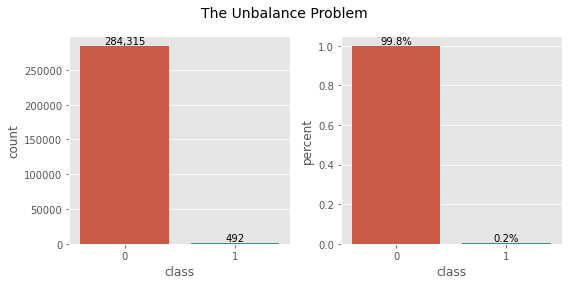

In [6]:
_ = plt.figure(figsize=[8,4])
plt.suptitle('The Unbalance Problem', fontsize=14)

plt.subplot(1,2,1)
ax = sns.barplot(
    data=pd.DataFrame(get_data_metrics(y, 'main', '')),
    x='class', y='count')
for container in ax.containers:
    labels = [f'{int(value):,}' for value in container.datavalues]
    ax.bar_label(container, labels, label_type='edge', color='black')
    
plt.subplot(1,2,2)
ax = sns.barplot(
    data=pd.DataFrame(get_data_metrics(y, 'main', '')),
    x='class', y='percent')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='edge', color='black')
plt.tight_layout()

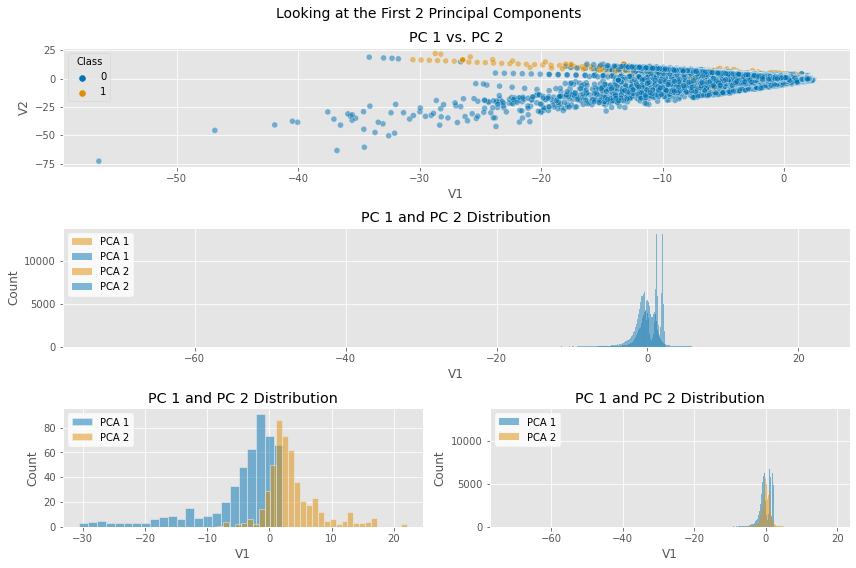

In [7]:
_ = plt.figure(figsize=[12,8])
plt.suptitle('Looking at the First 2 Principal Components', fontsize=14)

plt.subplot(3,1,1)
sns.scatterplot(data=df[['V1', 'V2', 'Class']], x='V1', y='V2', hue='Class', alpha=0.5, palette='colorblind')
plt.title('PC 1 vs. PC 2')

plt.subplot(3,1,2)
sns.histplot(
    data=df[['V1', 'Class']], x='V1', hue='Class', alpha=0.5, palette='colorblind', label='PCA 1')
sns.histplot(
    data=df[['V2', 'Class']], x='V2', hue='Class', alpha=0.5, palette='colorblind', label='PCA 2')
plt.title('PC 1 and PC 2 Distribution')
plt.legend(loc='upper left', frameon=True) \
    .get_frame().set_color('white')

plt.subplot(3,2,5)
sns.histplot(data=df.loc[df['Class'] == 1, 'V1'], alpha=0.5, color=COLORS[0], label='PCA 1')
sns.histplot(data=df.loc[df['Class'] == 1, 'V2'], alpha=0.5, color=COLORS[1], label='PCA 2')
plt.title('PC 1 and PC 2 Distribution')
plt.legend(loc='upper left', frameon=True) \
    .get_frame().set_color('white')

plt.subplot(3,2,6)
sns.histplot(data=df.loc[df['Class'] == 0, 'V1'], alpha=0.5, color=COLORS[0], label='PCA 1')
sns.histplot(data=df.loc[df['Class'] == 0, 'V2'], alpha=0.5, color=COLORS[1], label='PCA 2')
plt.title('PC 1 and PC 2 Distribution')
plt.legend(loc='upper left', frameon=True) \
    .get_frame().set_color('white')

plt.tight_layout()

## Resampling Methods for Many Float Ratios <a class="anchor" id="2-bullet"></a>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [9]:
from typing import List, Dict, Any
from imblearn.base import BaseSampler

def study_resampling_method(id_: str, res_method: BaseSampler, sampling_strategy_list: list
                           ) -> List[List[Dict[str, Any]]]:
    result = []
    for sampling_strategy in sampling_strategy_list:
        res = res_method(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
        X_train_res, y_train_res = res.fit_resample(X_train, y_train)
        data_metrics = get_data_metrics(y_train_res, 'train', f'{id_}({sampling_strategy})')
        result += data_metrics
    return result

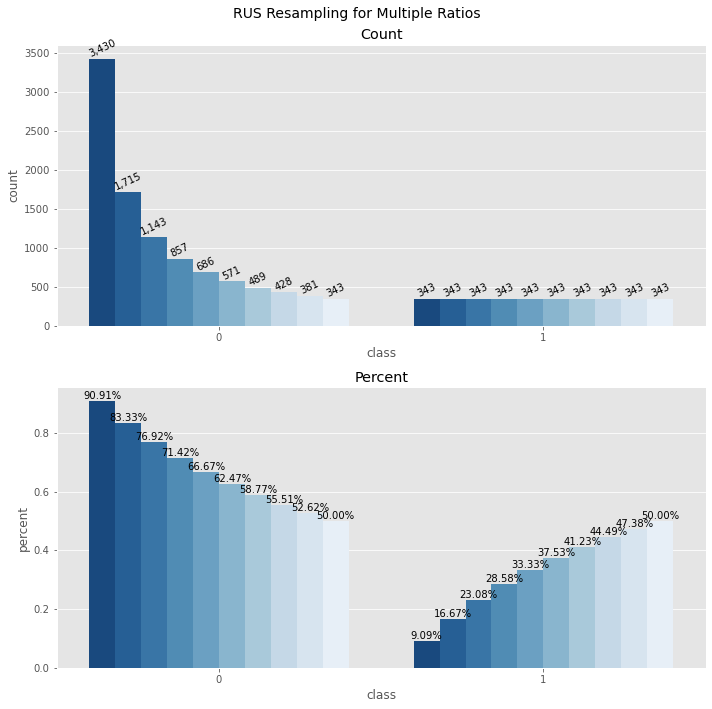

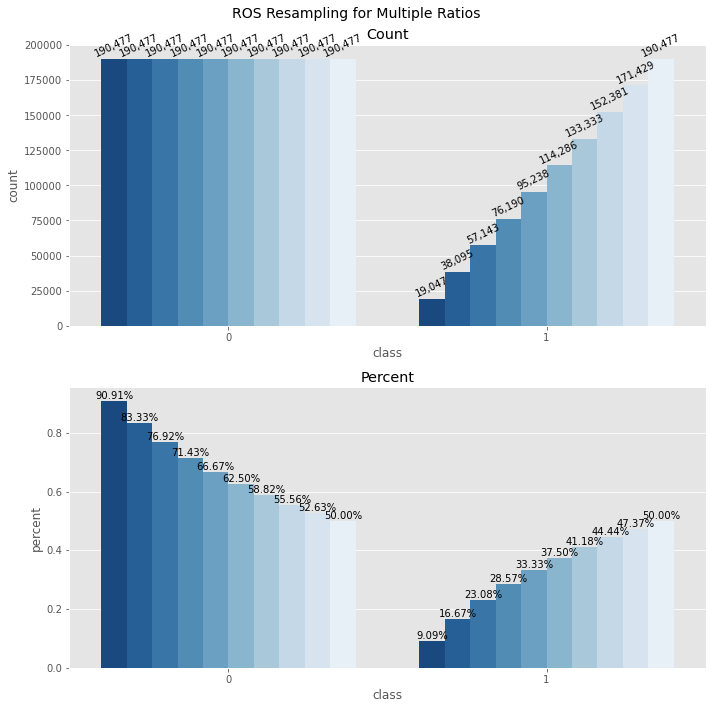

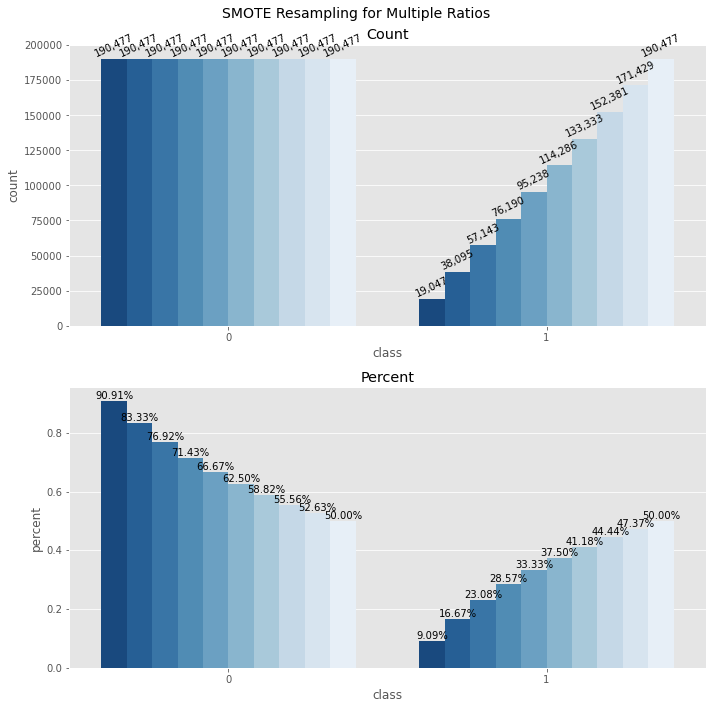

In [10]:
sampling_strategies = np.arange(0.1, 1.1, 0.1)
res_method_list = [
    ('RUS', RandomUnderSampler, sampling_strategies),
    ('ROS', RandomOverSampler, sampling_strategies),
    ('SMOTE', SMOTE, sampling_strategies),
]
for id_, res_method, sampling_strategy in res_method_list:
    result = study_resampling_method(id_, res_method, sampling_strategy)
    df = pd.DataFrame(result)
    
    _ = plt.figure(figsize=[10,10])
    plt.suptitle(f'{id_} Resampling for Multiple Ratios', fontsize=14)

    plt.subplot(2,1,1)
    ax = sns.barplot(
        data=pd.DataFrame(result),
        x='class',
        y='count',
        hue='exp_id',
        palette='Blues_r')
    plt.title('Count')
    plt.legend().remove()
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels, label_type='edge', color='black', rotation=25)

    plt.subplot(2,1,2)
    ax = sns.barplot(
        data=pd.DataFrame(result),
        x='class',
        y='percent',
        hue='exp_id',
        palette='Blues_r')
    plt.title('Percent')
    plt.legend().remove()
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)

    plt.tight_layout()

## Logistic Regression <a class="anchor" id="3-bullet"></a>

In [11]:
logistic_model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, n_jobs=N_JOBS)
logistic_model.fit(X_train, y_train);

In [12]:
y_pred = logistic_model.predict(X_test)
metrics = get_model_metrics(y_test, y_pred, 'None + LogReg', True)
metrics

{'is_resampled': True,
 'exp_id': 'None + LogReg',
 'f_score': 0.6980392156862745,
 'recall': 0.5973154362416108,
 'precision': 0.839622641509434,
 'g_mean': 0.7727918378303115,
 'roc_auc_score': 0.7985671364801056}

In [13]:
top_ten_features = pd.DataFrame(
    np.abs(logistic_model.coef_), 
    columns=logistic_model.feature_names_in_) \
    .T \
    .sort_values(0, ascending=False)[:10] \
    .index

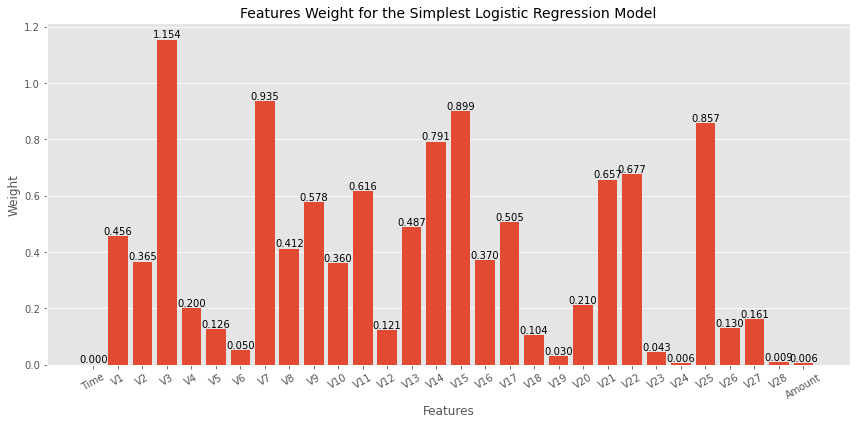

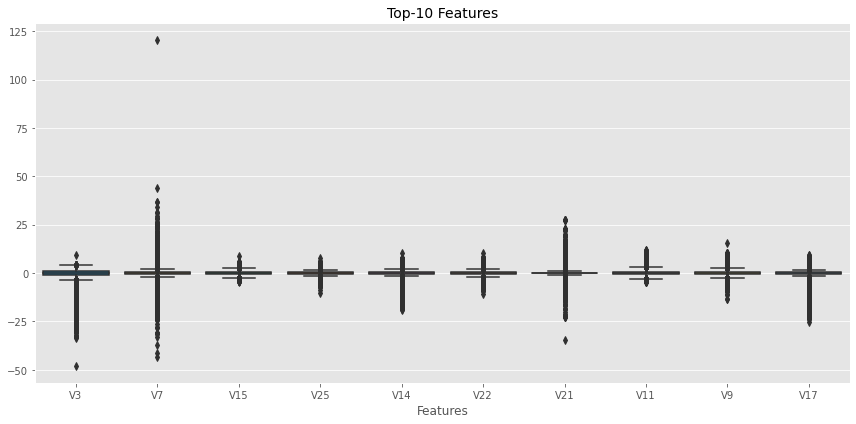

In [14]:
_ = plt.figure(figsize=[12,6])
bars = plt.bar(logistic_model.feature_names_in_, np.abs(logistic_model.coef_[0]))
plt.title('Features Weight for the Simplest Logistic Regression Model', fontsize=14)
for rect in bars:
    height = rect.get_height()
    plt.text(
        rect.get_x() + rect.get_width() / 2.0,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom')
plt.xticks(rotation=30)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.grid(axis='x')
plt.tight_layout()

_ = plt.figure(figsize=[12,6])
sns.boxplot(data=X[top_ten_features], palette='colorblind')
plt.title('Top-10 Features', fontsize=14)
plt.xlabel('Features')
plt.tight_layout()